# Introduction

This notebook is a data science project that predicts clickbait posts on Instagram (binary classification problem). The source of the data can be found here:xxx. The project begins with exploratory data analysis, followed by model testing and tuning, and concludes with business insights and recommendations.

## Import libraries and load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D #for train/test auc scores vis
import time 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [2]:
insta = pd.read_csv('C:/Datasets/Instagram.csv')
insta = insta.dropna()

# drop unnecessary text columns for this analysis 
insta = insta.drop(['Hashtags','Captions','SearchedTag'],axis=1)

# Explotary Analysis

In [3]:
insta.head()

,Likes,Comments,Followings,Followers,MediaCounts,LocationExistence,Clickbait,LengthOfHashtags,LengthOfCaptions,URLInclusion,...,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor
0,54,2,493,456,83,0,1,60,66,0,...,0.309000,0.71700,0.04220,0.00673,0.04840,0.945000,0.6560,0.1000,0.463000,0.04240
1,28,0,2210,1002,3268,0,0,178,178,0,...,0.000701,0.04360,0.00174,0.02650,0.93600,0.006180,0.0732,0.0202,0.000749,0.91200
2,111,4,572,3711,1101,0,1,301,353,0,...,0.000536,0.00178,0.00677,0.99800,0.00393,0.000688,0.9930,0.1710,0.000704,0.00275
3,41,0,99,109,102,0,1,261,397,0,...,0.002620,0.00915,0.06630,0.02580,0.90500,0.031200,0.9870,0.0730,0.005610,0.01460
4,5,0,334,174,254,0,1,37,124,0,...,0.009050,0.00695,0.20400,0.05440,0.90700,0.041500,0.9950,0.5250,0.012800,0.01000


In [4]:
# examine the dataset
insta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7759 entries, 0 to 7768
Data columns (total 27 columns):
Likes                        7759 non-null int64
Comments                     7759 non-null int64
Followings                   7759 non-null int64
Followers                    7759 non-null int64
MediaCounts                  7759 non-null int64
LocationExistence            7759 non-null int64
Clickbait                    7759 non-null int64
LengthOfHashtags             7759 non-null int64
LengthOfCaptions             7759 non-null int64
URLInclusion                 7759 non-null int64
MentionInclusion             7759 non-null int64
EmojiCount                   7759 non-null int64
EmojiExistence               7759 non-null int64
EmojiPortion                 7759 non-null float64
Top100HashOfInsta            7759 non-null int64
Top100HashWithinData         7759 non-null int64
Top100ComentionedHashPair    7759 non-null int64
Selfie                       7759 non-null float64
BodySna

In [5]:
insta.columns

Index(['Likes', 'Comments', 'Followings', 'Followers', 'MediaCounts',
       'LocationExistence', 'Clickbait', 'LengthOfHashtags',
       'LengthOfCaptions', 'URLInclusion', 'MentionInclusion', 'EmojiCount',
       'EmojiExistence', 'EmojiPortion', 'Top100HashOfInsta',
       'Top100HashWithinData', 'Top100ComentionedHashPair', 'Selfie',
       'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion', 'Face', 'Logo',
       'BrandLogo', 'Smile', 'Outdoor'],
      dtype='object')

In [6]:
# What's the % of Clickbait posts in this dataset?
benchmark = (insta.Clickbait == 1).sum()/insta.Clickbait.count()
print('Perecentage of Clickbait posts in the dataset: {:.1f}%'.format(benchmark*100))

Perecentage of Clickbait posts in the dataset: 45.1%


This can be our baseline accuracy metric. If a model simply guesses that every post in the dataset is clickbait, it would get 45% of them right. Inversely, if it guesses every post to be non-clickbait, it would be 55% right. Therefore, the minimum acceptable accuracy of our predictive model should be at least 55% to make our time and the cost of running it worth it.

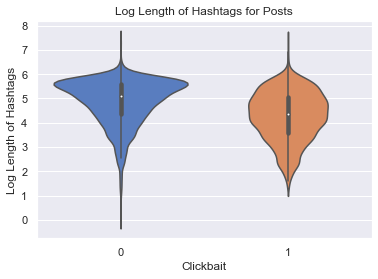

In [7]:
# visualize traits of posts and their relationship with Clickbait Posts 
sns.set()
sns.set_palette('muted')
sns.violinplot(data=insta, x='Clickbait', y=np.log(insta.LengthOfHashtags))
plt.ylabel('Log Length of Hashtags')
plt.title('Log Length of Hashtags for Posts')
plt.savefig('log length of hashtags.png')

Violin plots are less commonly used compared to boxplots, but I prefer them because they show a lot more information. The white dot in the middle is the median, the black bar is the inter-quartile range (25% - 75%), and the width shows the frequency. Note that the y-axis here is the natural log of length of hashtags. I expected clickbait posts to include more hashtags to cheat the recommendation system. This graphs shows that the length is more frequently higher for non-clickbait posts (between 5 - 6) compared to clickbait posts (4-5), a pattern that is against my intuition. The median length is also higher for non-clickbait posts. While this pattern is the opposite of what I expected, it could be helpful in the prediction of clickbait posts. (After seeing this graph I realized I began checking hashtag lengths on my Instagram feed a lot more.)

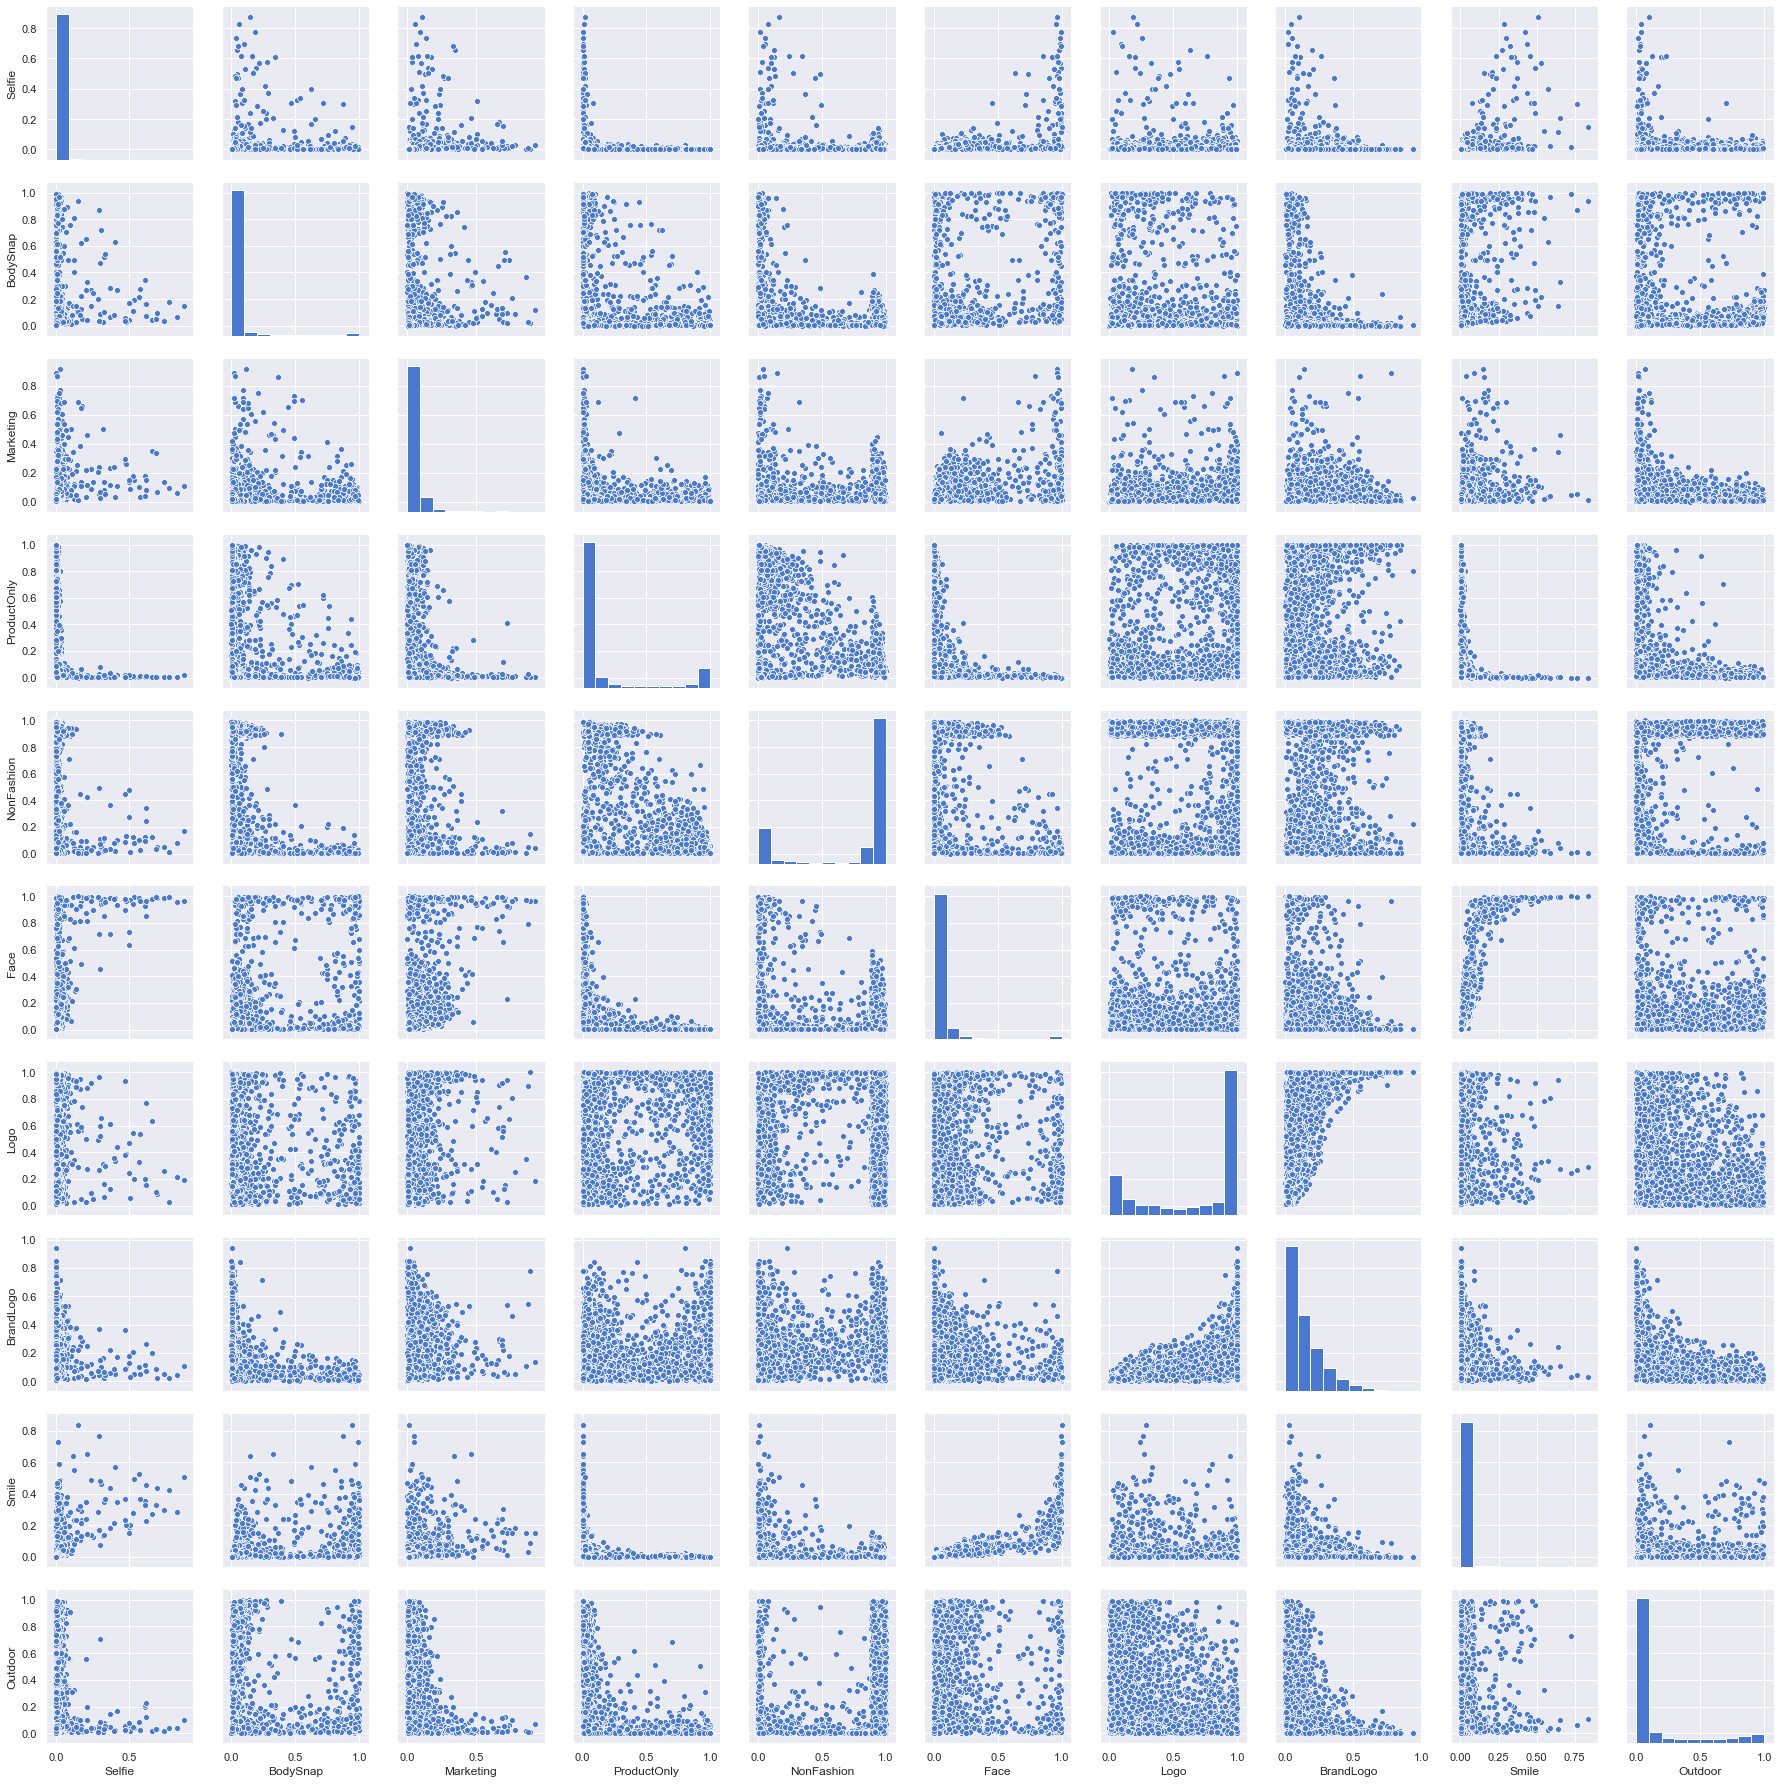

In [8]:
# pairplot for the picture attributes 
pictures = insta.iloc[:,17:]
sns.pairplot(data=pictures)
plt.savefig('picture traits.png')

As a sanity check, we can explore whether the probabilities that characterize the pictures are correct. For example, Face and Selfie are very similar traits, so the higher probability of a selfie the more likely it is to include a face. ProductOnly and Selfie are opposite traits, and the scatterplot does indicate that. An interesting relationshp is BrandLogo and BodySnap. Perhaps with body pictures the brand logo is so small it's unnoticeable, but it could exist. Face and Smile are also somewhat positive related. Maybe pictures with faces are more likely to be smiles. Logo and Outdoor relationship is undeterminable.

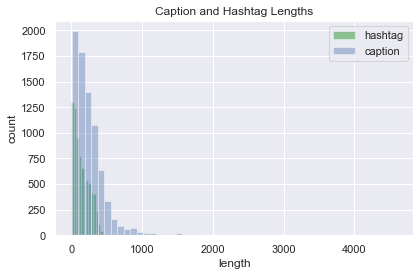

In [9]:
# Take a look at the distribution of length of hashtags and captions in the posts. I expect captions to be longer than hashtags. 
sns.set()
sns.distplot(insta.LengthOfHashtags, kde=False, label='hashtag', color='green')
sns.distplot(insta.LengthOfCaptions, kde=False, label='caption')
plt.title('Caption and Hashtag Lengths')
plt.ylabel('count')
plt.xlabel('length')
plt.legend()
plt.tight_layout()
plt.savefig('Caption and Hashtag Lengths.png')
plt.show()

In [10]:
# look at the posts with longest hashtags and captions
print(insta.loc[insta.LengthOfHashtags == insta.LengthOfHashtags.max()].Clickbait)
print(insta.loc[insta.LengthOfCaptions == insta.LengthOfCaptions.max()].Clickbait)

1631    0
Name: Clickbait, dtype: int64
5653    1
Name: Clickbait, dtype: int64


In [11]:
# emojis don't really indiciate which type of post it is 
print(insta.groupby('Clickbait')['EmojiExistence'].sum())

# URL inclusion. NonClickbaits have significantly more URL inclusion 
print(insta.groupby('Clickbait')['URLInclusion'].sum())

Clickbait
0    1608
1    1495
Name: EmojiExistence, dtype: int64
Clickbait
0    101
1     43
Name: URLInclusion, dtype: int64


# Modeling

In [12]:
# split into features and target
X = insta.drop('Clickbait',axis=1)
y = insta.Clickbait

# split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Logistic Regression

In [13]:
# show accuracy score of basic logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_logreg))

Logistic Regression accuracy: 0.5966494845360825


Logistic Regression 10-fold CV accuracy: 0.6201877286331892


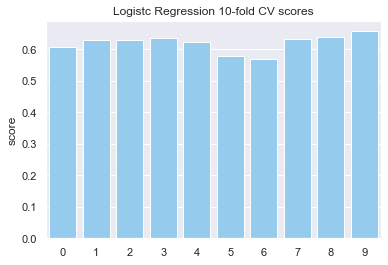

In [14]:
logreg_score = pd.DataFrame({"score":cross_val_score(logreg, X, y, cv=10)})
sns.barplot(data=logreg_score, x=logreg_score.index, y='score', color='lightskyblue')
plt.title('Logistc Regression 10-fold CV scores')

# average of the 10 fold
print("Logistic Regression 10-fold CV accuracy:", logreg_score.score.mean())

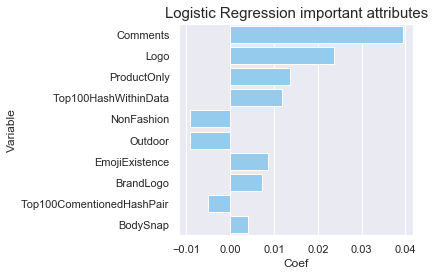

In [15]:
# visualize coefficients to determine which ones are more indicative of clickbait
logreg_df = pd.DataFrame(logreg.coef_, columns=X_train.columns)
logreg_df = logreg_df.transpose()
logreg_df = logreg_df.reset_index()
logreg_df.columns = ['Variable','Coef']

# sort by the absolute values of the variables
logreg_df['Abs Coef'] = abs(logreg_df.Coef)
logreg_df = logreg_df.sort_values(by='Abs Coef', ascending=False)

# plot the top 10 most important coefficients (by their absolute value)
sns.barplot(x='Coef', y='Variable', data=logreg_df.iloc[:10,], color='lightskyblue')
plt.title('Logistic Regression important attributes', fontdict = {'fontsize':15})
plt.tight_layout()
plt.savefig('Logistic Regression important attributes.png')

## Decision Tree

In [16]:
# Simple decision tree 
dt = DecisionTreeClassifier(random_state=21)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print('Decision Tree accuracy: {:.3f}'.format(dt_accuracy))

Decision Tree accuracy: 0.783


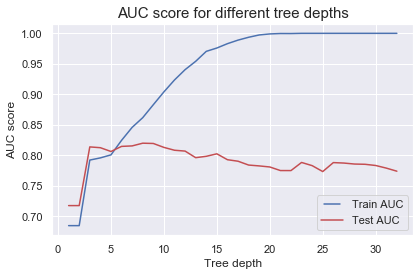

In [17]:
# tuning max_depth as a parameter example. 
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)


# visualize max_depth train/test auc
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)}, loc=4)
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title('AUC score for different tree depths', fontdict = {'fontsize':15})
plt.tight_layout()
plt.savefig('AUC score for different tree depths.png')
plt.show()

We can see that the test AUC score follows a decreasing trend starting from approximately 7 or 8 depth

In [18]:
# find which depth has the highest test AUC score
df = pd.DataFrame({"depth":max_depths, "train_auc":train_results, "test_auc":test_results})
df.test_auc.idxmax()

7

In [19]:
# what is the train & test AUC score
df.iloc[df.test_auc.idxmax(),]

depth        8.000000
train_auc    0.861666
test_auc     0.819837
Name: 7, dtype: float64

### Tuning the tree

In [20]:
# create a liust of max_depth
max_depth_array=np.linspace(2,10, num=9)
# GridSearch
params_dt = {'max_depth':max_depth_array.tolist(),
             'min_samples_leaf':[0.12,0.14,0.16,0.18]}
# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=10,
                       n_jobs=-1)

In [21]:
#fit the model
grid_dt.fit(X, y)

# See the best parameters
print(grid_dt.best_params_)

# Extract the best estimator
dt_best_model = grid_dt.best_estimator_

# Print the best ROC_AUC score 
print('dt best AUC score: {:.3f}'.format(grid_dt.best_score_))

{'max_depth': 4.0, 'min_samples_leaf': 0.12}
dt best AUC score: 0.858


In [22]:
# Predict the test set probabilities of the positive class
y_pred_proba = dt_best_model.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test,y_pred_proba)

# Print test_roc_auc
print('Decision Tree test set AUROC score: {:.3f}'.format(test_roc_auc))

Decision Tree test set AUROC score: 0.875


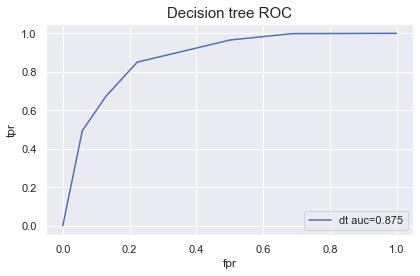

In [23]:
dt_y_pred_proba = dt_best_model.predict_proba(X_test)[:,1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_proba)
dt_auc = roc_auc_score(y_test, dt_y_pred_proba)

# visualize the ROC curve 
sns.set()
sns.lineplot(dt_fpr,dt_tpr,label="dt auc="+str(round(dt_auc,3)))
plt.title('Decision tree ROC', fontdict = {'fontsize':15})
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('Decision tree ROC.png')
plt.show()

## Random Forest

In [24]:
rf = RandomForestClassifier(random_state=21)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy: {:.3f}".format(rf_accuracy))
print("Decision Tree accuracy: {:.3f}".format(dt_accuracy))

Random Forest accuracy: 0.847
Decision Tree accuracy: 0.783


In [25]:
# Compare using 10-fold cross validation
rf_cv_accuracy = np.mean(cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy'))
dt_cv_accuracy = np.mean(cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy'))
print("Random Forest cv accuracy: {:.3f}".format(rf_cv_accuracy))
print("Decision Tree cv accuracy: {:.3f}".format(dt_cv_accuracy))

Random Forest cv accuracy: 0.825
Decision Tree cv accuracy: 0.759


We can already see that the random forest model is better than the decision tree based on a simple accuracy score metric. I chose to only perform cross validation on training set instead of entire dataset because I want to use the test data as a final unbiased evaluation of the model's performance. 

### Tuning Random Forest

In [26]:
start_time = time.time()

params_rf = {'n_estimators':[300,500,800],
             'min_samples_leaf':[0.1,0.5,1,2]
}

grid_rf = GridSearchCV(estimator=rf, 
                       param_grid=params_rf, 
                       scoring='roc_auc', 
                       cv=5, 
                       verbose=1, 
                       n_jobs=-1)

# fit on the training data 
grid_rf.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


--- 113.69575834274292 seconds ---


In [27]:
# Extract the best estimator
rf_best_model = grid_rf.best_estimator_

# See the best parameters
print(grid_rf.best_params_)

# Print best score 
print("Decision Tree accuracy: {:.3f}".format(grid_rf.best_score_))

{'min_samples_leaf': 1, 'n_estimators': 800}
Decision Tree accuracy: 0.912


In [28]:
# Predict test set labels
y_pred_rf = rf_best_model.predict(X_test)
rf_best_accuracy = accuracy_score(y_test, y_pred_rf)
print("rf best model accuracy: {:.3f}".format(rf_best_accuracy))

rf best model accuracy: 0.853


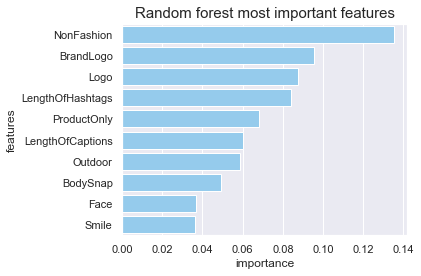

In [29]:
# visualize the top 10 most important characteristics used in the model 
feature_importances = pd.DataFrame(rf_best_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

feature_importances = feature_importances.reset_index().head(10)
sns.barplot(data=feature_importances, x='importance', y='index', color='lightskyblue')
plt.title('Random forest most important features', fontdict = {'fontsize':15})
plt.ylabel('features')
plt.tight_layout()
plt.savefig('Random forest most important features.png')

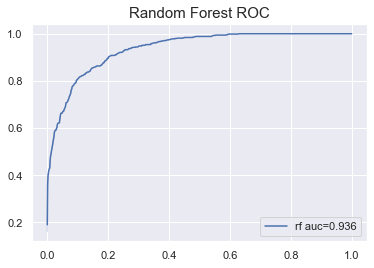

In [30]:
# visualize the ROC
rf_y_pred_proba = rf_best_model.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba)
rf_auc = roc_auc_score(y_test, rf_y_pred_proba)

sns.lineplot(rf_fpr,rf_tpr,label="rf auc="+str(round(rf_auc,3)))
plt.title('Random Forest ROC', fontdict = {'fontsize':15})
plt.legend(loc=4)
plt.show()

## XGBoost

In [31]:
#initiate 
xgb_class=XGBClassifier()

# turn X_train, y_train to dmatrix 
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# define some params for GridSearch
max_depth = [5,6,7,8]
learning_rate = [0.01, 0.1, 0.2]
colsample_bytree_vals = [0.5, 0.8, 1]
num_boost_rounds = 50

# Tuning the xgb model. This will take a while 
start_time = time.time()

xgb_param_grid = {"max_depth": max_depth,
                  "learning_rate": learning_rate,
                  "colsample_bytree":colsample_bytree_vals}

xgb_grid = GridSearchCV(xgb_class, xgb_param_grid, scoring="roc_auc", cv=5, verbose=1)
xgb_grid.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.2min finished


--- 253.6390516757965 seconds ---


In [32]:
print("Best parameters found: ", xgb_grid.best_params_)
print("Highest AUC found for xgb: {:.3f}".format(xgb_grid.best_score_))

Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8}
Highest AUC found for xgb: 0.915


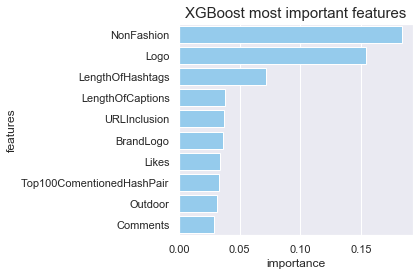

In [33]:
# visualize the top 10 most important characteristics used in the xgb model 
xgb_best_model = xgb_grid.best_estimator_
feature_importances = pd.DataFrame(xgb_best_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

feature_importances = feature_importances.reset_index().head(10)
sns.barplot(data=feature_importances, x='importance', y='index', color='lightskyblue')
plt.title('XGBoost most important features', fontdict = {'fontsize':15})
plt.ylabel('features')
plt.tight_layout()
plt.savefig('XGBoost most important features.png')

The first thing I noticed is that these variables are very similar to those chosen by the random forest model, but with a difference in the magnitudes. From the two graphs, we can find a consistent pattern: non-fashion pictures, pictures with logos, and length of hashtags used in the posts are significant contributors to the determination of a clickbait post. There is clearly a top 3 as opposed to the previous graph. URL inclusion is also important here, but not for the random forest model.However, since these numbers are not coefficients, we cannot determine if an increase or decrease in any of these features will make the post more likely or less likely to be a clickbait post. They merely sheds some light into which variables the model finds that have a strong effect on the predicted output. 

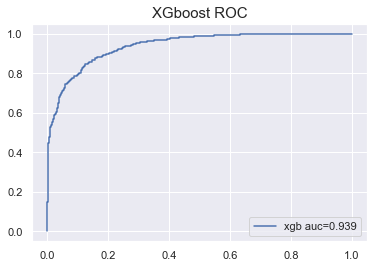

In [34]:
# visualize the ROC curve 
xgb_y_pred_proba = xgb_best_model.predict_proba(X_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_proba)
xgb_auc = roc_auc_score(y_test, xgb_y_pred_proba)
plt.plot(xgb_fpr,xgb_tpr,label="xgb auc="+str(round(xgb_auc,3)))
plt.title('XGboost ROC', fontdict = {'fontsize':15})
plt.legend(loc=4)
plt.show()

## Neural Network (experimentation)

In [35]:
y_train_array = np.asarray(y_train)
X_train_array = np.asarray(X_train)

# Initiate the model: model
model1 = Sequential()
# Add the first hidden layer
model1.add(Dense(50, activation='relu', input_shape=(26,)))
# Add the second hidden layer
model1.add(Dense(50, activation='relu'))
# Add the output layer
model1.add(Dense(2, activation='softmax'))
# Compile the model 
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Fit the model 
model1.fit(X_train_array, y_train_array, validation_split=0.2)

Train on 4965 samples, validate on 1242 samples
4965/4965 [==============================] - 1s 272us/sample - loss: 51.0617 - accuracy: 0.5426 - val_loss: 30.4037 - val_accuracy: 0.4694


In [36]:
X_test_array = np.asarray(X_test)
y_pred_nn1 = model1.predict_classes(X_test_array)
print("deep learning model 1 accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_nn1)))

deep learning model 1 accuracy score: 0.463


In [37]:
# test a more complex deep learning model 
# Initiate the model: model
model2 = Sequential()
# Add the first hidden layer
model2.add(Dense(100, activation='relu', input_shape=(26,)))
# Add the second hidden layer
model2.add(Dense(100, activation='relu'))
# Add the third hidden layer 
model2.add(Dense(100, activation='relu'))
# Add the output layer
model2.add(Dense(2, activation='softmax'))
# Compile the model 
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Fit the model 
model2.fit(X_train_array, y_train_array, validation_split=0.2)

Train on 4965 samples, validate on 1242 samples
4965/4965 [==============================] - 1s 146us/sample - loss: 62.4501 - accuracy: 0.5259 - val_loss: 13.7617 - val_accuracy: 0.5129


In [38]:
X_test_array = np.asarray(X_test)
y_pred_nn2 = model2.predict_classes(X_test_array)
print("deep learning model 2 accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_nn2)))

deep learning model 2 accuracy score: 0.523


# Model Comparison & Insights

In [39]:
# xgb predict outcomes 
y_pred_xgb = xgb_best_model.predict(X_test)
xgb_best_accuracy = accuracy_score(y_test, y_pred_xgb)

# compare all 3 model's accuracy 
print("XGBoost best model accuracy: {:.3f}".format(xgb_best_accuracy))
print("Random Forest accuracy: {:.3f}".format(rf_accuracy))
print("Decision Tree accuracy: {:.3f}".format(dt_accuracy))

XGBoost best model accuracy: 0.860
Random Forest accuracy: 0.847
Decision Tree accuracy: 0.783


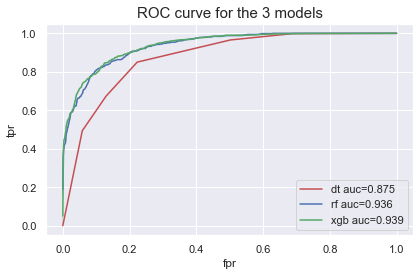

In [40]:
# plot all of the ROC cuves
sns.lineplot(dt_fpr,dt_tpr,label="dt auc="+str(round(dt_auc,3)), color='r')
sns.lineplot(rf_fpr,rf_tpr,label="rf auc="+str(round(rf_auc,3)), color='b')
sns.lineplot(xgb_fpr,xgb_tpr,label="xgb auc="+str(round(xgb_auc,3)), color='g')
plt.legend(loc=4)
plt.title('ROC curve for the 3 models', fontdict = {'fontsize':15})
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.tight_layout()
plt.savefig('ROC curve for the 3 models.png')

  model       auc  accuracy
0   xgb  0.914558  0.860180
1    rf  0.911950  0.853093
2    dt  0.858240  0.782861


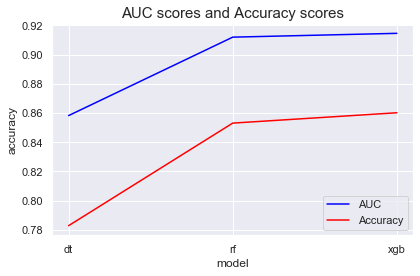

In [42]:
# visualizing outputs 
model = ['xgb', 'rf', 'dt']
auc_scores = [xgb_grid.best_score_, grid_rf.best_score_, grid_dt.best_score_]
accuracy_scores = [xgb_best_accuracy, rf_best_accuracy, dt_accuracy]

scores = pd.DataFrame({"model":model,
                       "auc":auc_scores,
                       "accuracy":accuracy_scores})
print(scores)

# combining the two graphs
sns.lineplot(data=scores, x='model', y='auc', color='blue', label='AUC')
sns.lineplot(data=scores, x='model', y='accuracy', color='red', label='Accuracy')
plt.title('AUC scores and Accuracy scores', fontdict = {'fontsize':15})
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('AUC scores and Accuracy scores.png')

From a business perspective, should we care more about False Positives(inaccurately predicting non-clickbait as clickbait) or False Negatives(inaccurately predicting clickbait as non-clickbait)? The latter would allow clickbait posts to continue existing in the system and dilute user experience to some extent, but the former could result in the post being removed from recommendation feeds and cause great frustration if it were a paid post. The poster could even suffer financial losses due to poor exposure of the post. My thinking is that False Positives should be punished more heavily because they can cause more harm, so we need to examine the precision score, which calculates exactly that. 

In [43]:
# take a look at the precision score of the models. 
dt_y_pred = dt_best_model.predict(X_test)
rf_y_pred = rf_best_model.predict(X_test)
xgb_y_pred = xgb_best_model.predict(X_test)

dt_precision = precision_score(y_test, dt_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)

# compare all 3 model's accuracy 
print("XGBoost precision: {:.3f}".format(xgb_precision))
print("Random Forest precision: {:.3f}".format(rf_precision))
print("Decision Tree precision: {:.3f}".format(dt_precision))
print("xgb precision improvement over rf: {:.1f} %".format((xgb_precision/rf_precision-1)*100))

XGBoost precision: 0.841
Random Forest precision: 0.828
Decision Tree precision: 0.756
xgb precision improvement over rf: 1.6 %


  model  precision
0   xgb   0.841429
1    rf   0.828411
2    dt   0.755754


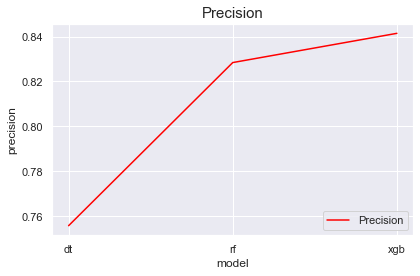

In [44]:
# visualizing outputs 
model = ['xgb', 'rf', 'dt']
precision_scores = [xgb_precision, rf_precision, dt_precision]

scores = pd.DataFrame({"model":model,
                       "precision":precision_scores})
print(scores)

# combining the two graphs
sns.lineplot(data=scores, x='model', y='precision', color='red', label='Precision')
plt.title('Precision', fontdict = {'fontsize':15})
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('Precision.png')
plt.show()

XGboost just barely outperforms random forest on this metric. With it requiring signifcantly more compupting power and taking longer to run, I do not think the cost justifies the reward. At the end of the day, I would recommend the random forest model for future predictions. 

In [45]:
# compare the model of choice to initial benchmark 
print("Clickbait benchmark percentage: {:.3f}%".format(benchmark*100))
print("XGBoost model accuracy: {:.3f}%".format(xgb_precision*100))
print("Accuracy outperformance: {:.3f}%".format((xgb_precision - benchmark)*100))

Clickbait benchmark percentage: 45.148%
XGBoost model accuracy: 84.143%
Accuracy outperformance: 38.995%
